# Deep Unsupervised Learning 
We will now focus on deep learrning on large, unlabeled datasets: *deep unsupervised learning*. 

This is a very new field, full of potential but with fewer commericial sucesses as of date. 

# Boltzmann Machines
Now we will move into *generative unsupervised models* which involve learning a probability distribution from an original dataset and using it to make inferences about never before seen data. 

We have mainly looked at *discriminative models* that learn to seperate observaations based on waht the algorithms learn from the data. 

These discriminative models do not learn the probability distribution from the data. Discrimiative models such as: logistic regression, decision trees, clustering methods. 

Boltzmann machines (unrestricted) consist of a neural network with an input layer and one or several hidden layers. The neurons or units in the neural network make stochastic decisions about whether to turn on or not based on the data fed in during training and the cost function they are trying to minimize. 

It discovers interesting features about the data, which helps model the complex underlying relationships and patterns present in the data. 

These Boltzmann machines use neural networks with neurons that are connected not only to other neurons in other layers but also to neurons within the same layer. 

## Restricted Boltzmann Machines
RBMs have an input layer (visible layer) and just a single hidden layer, and the connections among neurons are restricted such that neurons are connected only to the neurons in other layers but not to neurons within the same layer. 

Therefor: No visible-visible connections and no hidden-hidden connections.

RBMs stacked on top of each other essentially make up for a what's now known as the field of deep learning. 

RBMs use a *stochastic* approach to learning the underlying structure of data, whereas autoencoders use a *deterministic* approach. 

## Recommender Systems
We will use RBMs to build a *recommender system*, one of the most successful applications of machine learning to date and widely used in industry to help user preference for movies, music, books, news, search, shopping, digital advertising, and online dating. 

There are **collaborative filtering** systems and **content-based filtering** recommender systems. 

*Collaborative filtering* involves building a recommender system from a user's past behavior and those of other users to which the user is similar to. 

This recommender system can then predict items that the user may have an interest in even though the user has never expressed explicit interest. (netflix uses this system) 

*Content-based filtering* involves learning the distinct properties of an item to recommend additional items with similar properties. 

### Collaborative Filtering
Content-based filtering is not commonly used because it is a rather difficult task to learn the distinct properties of items - this level of understanding is very challenging for artificial machines to achieve currently. 

It is much easier to collect and analyze a large amount of information on user's behavior and preferences and make predictions based on this. 

Collaborative filtering requires no knowledge of the underlying items themselves. Rather, collaborative filtering assumes that users taht agreed in the past will agree in the future and that user preferences remain stable over time. 

By modeling how similar users are to other users, collaborative filtering can make pretty powerful recommendations. 

Collaborative filtering does not have to rely on *explicit data* (rating that users provide). Rather, it can work with *implicit data* such as how long or how often a user views or clicks on a particular item. 

*example: Netflix would ask users to rate movies but now uses implicit user behavior to make inferences about user likes and dislikes*

### MoveLens Dataset
We will use a movie ratings dataset known as *MovieLens 20M Dataset*. This dataset contains 20,000,263 ratings across 27,278 movies created by 138,493 users of users who rated at least 20 movies each. 

In [3]:
# # downloading our data
# !curl 'http://files.grouplens.org/datasets/movielens/ml-20m.zip' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Connection: keep-alive' -H 'Cookie: _ga=GA1.2.112438606.1560196437; _gid=GA1.2.1915689949.1560196437; _gat=1' -H 'Upgrade-Insecure-Requests: 1' -o ./datasets/movielens.zip

# # unzip
# !unzip ./datasets/movielens.zip

# # remove zipped file
# !rm -rf ./datasets/movielens.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189M  100  189M    0     0  16.5M      0  0:00:11  0:00:11 --:--:-- 20.4M
Archive:  ./datasets/movielens.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [8]:
# # Moving our downloaded data to datasets directory
# !mv ml-20m/* datasets/

In [1]:
# Importing our libraries
import numpy as np
import pandas as pd
import os, time, re, pickle, gzip, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score, mean_squared_error

import lightgbm as lgb
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [125]:
from keras.layers import Flatten

In [121]:
from keras.layers import Embedding

In [131]:
from keras.layers import dot

In [2]:
# Loading our data
file = './datasets/ratings.csv'

rating_DF = pd.read_csv(file)

In [3]:
rating_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [4]:
rating_DF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
# coverting timestamp
rating_DF['timestamp'] = rating_DF['timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d%H:%M:%S'))

In [5]:
rating_DF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-0223:53:47
1,1,29,3.5,2005-04-0223:31:16
2,1,32,3.5,2005-04-0223:33:39
3,1,47,3.5,2005-04-0223:32:07
4,1,50,3.5,2005-04-0223:29:40


In [6]:
rating_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    object
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


We will take a sample of our data to minimize the size. As you can see the original file sie is just about 600MB which can become hard to process unless using tools such as: Dask, etc. 

We will only focus on the top 1000 most rates movies

In [7]:
# Grabbing index of top 1000 rates movies
movie_index = rating_DF.groupby('movieId').count().sort_values(by="rating", ascending=False)[0:1000].index

In [8]:
# Let's form the new dataframe
rating_DF_2 = rating_DF[rating_DF['movieId'].isin(movie_index)]

In [9]:
rating_DF_2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [10]:
rating_DF_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12840344 entries, 0 to 20000261
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    object
dtypes: float64(1), int64(2), object(1)
memory usage: 489.8+ MB


In [12]:
import gc

In [14]:
# clearing memory
# del rating_DF
gc.collect()

0

In [15]:
del rating_DF

We will now further decrease the size by taking a sample of one thousand users at random and filter the dataset for just these users

In [16]:
# grabbing user index
user_index = rating_DF_2.groupby('userId').count().sort_values(by='rating', ascending=False).sample(n=1000, random_state=2018).index

In [17]:
# Creating new DF
rating_DF_3 = rating_DF_2[rating_DF_2['userId'].isin(user_index)]

In [18]:
rating_DF_3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [19]:
rating_DF_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90213 entries, 4943 to 19955685
Data columns (total 4 columns):
userId       90213 non-null int64
movieId      90213 non-null int64
rating       90213 non-null float64
timestamp    90213 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 3.4+ MB


In [20]:
# Clearing memory
del rating_DF_2
gc.collect(); gc.collect()

0

In [21]:
rating_DF_3.head()

,userId,movieId,rating,timestamp
4943,49,50,5.0,2013-05-0302:50:26
4944,49,163,3.5,2013-05-0302:43:37
4945,49,216,3.0,2013-05-0302:45:58
4946,49,296,5.0,2013-05-0302:50:13
4947,49,333,3.0,2013-05-0302:44:38


In [22]:
rating_DF_3.shape

(90213, 4)

In [24]:
# Reindexing movieId and userId to a range of 1 to 1000
movies = rating_DF_3['movieId'].unique()
movies_DF = pd.DataFrame(data=movies, columns=['original_movie_id'])
movies_DF['new_movie_id'] = movies_DF.index + 1

In [28]:
# users
users = rating_DF_3['userId'].unique()
user_DF = pd.DataFrame(data=users, columns=['original_user_id'])
user_DF['new_user_id'] = user_DF.index + 1

In [30]:
rating_DF_3 = rating_DF_3.merge(movies_DF, left_on='movieId', right_on='original_movie_id')
rating_DF_3.drop(labels='original_movie_id', axis=1, inplace=True)

In [35]:
rating_DF_3 = rating_DF_3.merge(user_DF, left_on='userId', right_on='original_user_id')
rating_DF_3.drop(labels='original_user_id', axis=1, inplace=True)

In [36]:
rating_DF_3.head()

,userId,movieId,rating,timestamp,new_movie_id,new_user_id
0,49,50,5.0,2013-05-0302:50:26,1,1
1,49,163,3.5,2013-05-0302:43:37,2,1
2,49,216,3.0,2013-05-0302:45:58,3,1
3,49,296,5.0,2013-05-0302:50:13,4,1
4,49,333,3.0,2013-05-0302:44:38,5,1


In [45]:
# Recalculating 
n_users = rating_DF_3['userId'].nunique()
n_movies = rating_DF_3['movieId'].nunique()
n_ratings = len(rating_DF_3)
avg_ratings_per_user = n_ratings / n_users

In [46]:
# Creating test train split
X_train, X_test = train_test_split(rating_DF_3, test_size=0.10, shuffle=True, random_state=2018)

# Creating new split on X_train
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [49]:
# sizes
print(len(X_train))
print(len(X_validation))
print(len(X_test))

81191
4511
4511


In [50]:
X_train.head()

,userId,movieId,rating,timestamp,new_movie_id,new_user_id
77796,118358,2918,4.0,2005-03-1713:11:50,725,841
20109,48345,1907,3.0,2003-01-2605:32:21,345,347
61046,25880,74458,4.0,2010-11-2109:47:32,75,180
58074,73713,39,4.0,1999-02-0705:07:01,465,522
77706,117584,590,4.0,1996-09-1108:24:35,255,831


In [51]:
X_test.head()

,userId,movieId,rating,timestamp,new_movie_id,new_user_id
3750,9563,480,3.0,1996-06-2521:47:44,112,76
31667,84140,1682,4.0,2007-07-2207:28:53,54,579
38850,103394,1517,1.0,1999-12-1216:08:19,569,725
78158,132306,1214,3.0,2000-08-0318:12:49,139,945
57372,63228,2161,0.5,2004-10-1118:51:37,349,447


In [52]:
X_validation.head()

,userId,movieId,rating,timestamp,new_movie_id,new_user_id
58632,104102,3578,5.0,2013-09-2911:54:04,234,731
6501,20257,1284,4.0,1997-02-0601:18:50,861,137
45799,125007,2959,5.0,2008-03-2819:43:53,64,893
7180,20579,5218,4.0,2005-03-0519:56:49,379,145
143,311,546,1.0,2001-02-1816:09:41,115,3


In [57]:
# Generating training matrix for train
ratings_train = np.zeros((n_users, n_movies))

for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [91]:
# Calculating sparsity of the train matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100

In [92]:
sparsity

8.1191

In [93]:
# Generating a similar matrix for both validation and test
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]
    
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

### Defining Cost Function
We will use **mean squared error** to measure the goodness of our model. MSE measures the averaged squared error between the predicted valuesand the actual values. 

To calculate the MSE, we need two vectors of size [n,1], where $n$ is the number of ratings we are predicting.

One vector has the actual ratings, and the other vector has the predictions. 

We will flatten the sparse matrix with the ratings for the validation set. This will be the vector of actual ratings. 

In [97]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [106]:
actual_validation[:10]

array([3., 1., 3., 5., 4., 3., 2., 3., 2., 1.])

### Perform Baseline Experiments
As a baseline, let's predict an average rating of 3.5 for the validation set and calculate the MSE

In [108]:
pred_validation = np.zeros((len(X_validation), 1))

In [110]:
pred_validation[pred_validation==0] = 3.5

In [112]:
mean_squared_error(pred_validation, actual_validation)

1.055420084238528

## Matrix Factorization
We will first build a recommendation system using *matrix factorization*, one of the most successful.

Matrix factorization decomposes the user-item matrix into a product of two lower dimensionality matrices. 

Users are represented in lower dimensional latent space, and so are items. 

Assume our user-item matrix is $R$, with $m$ users and $n$ items. Matrix factorization will create two lower dimensionality matrices, $H$ and $W$. 

$H$ is an $m$ users $*$ $k$ latent factors matrix. 

$W$ is a $k$ latent factors $*$ $n$ items matrix. 

The ratings are computed by matrix multiplication: $R = H * W$

The number of $k$ latent factors determines the **capacity** of the model. The higher the $k$, the greater the capacity of the model. By increasing $k$, we can improve the personalization of rating predictions for users, but, if $k$ is too high, the model will **overfit** the data. 

Matrix factorization learns representations for the users and items in a lower dimensional space and makes predictions based on the newly learned representations. 

### One Latent Factor
We will begin with the simplest form of matrix factorization with just one latent factor. 

The input is the one-dimensional vector of users for the user embedding and the one-dimensional vector of movies for the movie embedding. 

We will embed these input vectors into a latent space of one and then flatten them. 

To generate the output vector product, we will take the dot product of the movie vector and user vector. 

We will use the *Adam Optimizer* to minimize our cost function: Which will be *mean squared error* 

In [127]:
n_latent_factors = 1

In [128]:
user_input = Input(shape=[1], name='user')

user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)

user_vec = Flatten(name='flatten_users')(user_embedding)

In [129]:
movie_input = Input(shape=[1], name='movie')

movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)

movie_vec = Flatten(name='flatten_movies')(movie_embedding)

In [140]:
# Output representing the predicted ratings 
product = dot([movie_vec, user_vec], axes=1)

# instantiating model
model = Model(inputs=[user_input, movie_input], outputs=product)

# compiling out model with loss and error
model.compile('adam', 'mean_squared_error')

# Training the model
history = model.fit(
    x=[X_train['new_user_id'], X_train['new_movie_id']],
    y = X_train['rating'],
    epochs = 100,
    validation_data=([X_validation['new_user_id'], X_validation['new_movie_id']], X_validation['rating']),
    verbose = 1
)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 3s 31us/step - loss: 13.3915 - val_loss: 11.4275
Epoch 2/100
81191/81191 [==============================] - 2s 28us/step - loss: 8.7148 - val_loss: 6.1987
Epoch 3/100
81191/81191 [==============================] - 2s 28us/step - loss: 4.4242 - val_loss: 3.2204
Epoch 4/100
81191/81191 [==============================] - 2s 28us/step - loss: 2.4735 - val_loss: 2.0030
Epoch 5/100
81191/81191 [==============================] - 2s 28us/step - loss: 1.6108 - val_loss: 1.4177
Epoch 6/100
81191/81191 [==============================] - 2s 27us/step - loss: 1.1816 - val_loss: 1.1238
Epoch 7/100
81191/81191 [==============================] - 2s 27us/step - loss: 0.9646 - val_loss: 0.9726
Epoch 8/100
81191/81191 [==============================] - 2s 28us/step - loss: 0.8534 - val_loss: 0.8920
Epoch 9/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7953 - val_loss: 0.

In [146]:
# Plotting Function
def lr_plot(history_):
    # Plotting our loss with epochs
    pd.Series(history_.history['val_loss'][10:]).plot(logy=False)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Error')
    print('Minimum MSE: ', min(history.history['val_loss']))

Minimum MSE:  0.7959770727807681


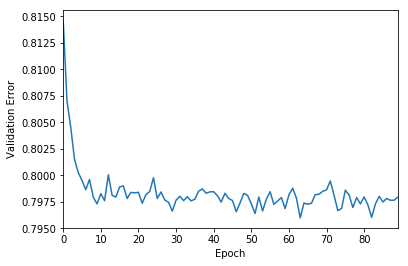

In [147]:
lr_plot(history)

### Three Latent Factors

In [149]:
# Helper functions
def latent_test(n_latent_factors):
    user_input = Input(shape=[1], name='user')

    user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)

    user_vec = Flatten(name='flatten_users')(user_embedding)

    movie_input = Input(shape=[1], name='movie')

    movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)

    movie_vec = Flatten(name='flatten_movies')(movie_embedding)
    
    return movie_vec, user_vec, user_input, movie_input

def train_model(movie_vec_, user_vec_, user_input_, movie_input_):
    # Output representing the predicted ratings 
    product = dot([movie_vec_, user_vec_], axes=1)

    # instantiating model
    model = Model(inputs=[user_input_, movie_input_], outputs=product)

    # compiling out model with loss and error
    model.compile('adam', 'mean_squared_error')

    # Training the model
    history = model.fit(
        x=[X_train['new_user_id'], X_train['new_movie_id']],
        y = X_train['rating'],
        epochs = 100,
        validation_data=([X_validation['new_user_id'], X_validation['new_movie_id']], X_validation['rating']),
        verbose = 1
    )
    
    return history

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 3s 31us/step - loss: 12.9379 - val_loss: 9.0822
Epoch 2/100
81191/81191 [==============================] - 2s 28us/step - loss: 5.1066 - val_loss: 2.7730
Epoch 3/100
81191/81191 [==============================] - 2s 28us/step - loss: 1.9078 - val_loss: 1.4248
Epoch 4/100
81191/81191 [==============================] - 2s 29us/step - loss: 1.1164 - val_loss: 1.0136
Epoch 5/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.8648 - val_loss: 0.8738
Epoch 6/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7809 - val_loss: 0.8248
Epoch 7/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7522 - val_loss: 0.8079
Epoch 8/100
81191/81191 [==============================] - 2s 28us/step - loss: 0.7420 - val_loss: 0.8032
Epoch 9/100
81191/81191 [==============================] - 2s 28us/step - loss: 0.7377 - val_loss: 0.8

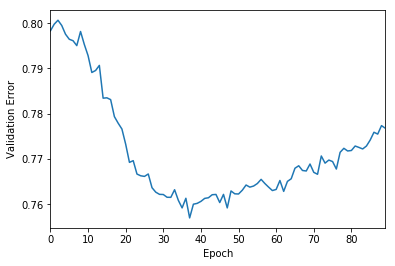

In [150]:
# 3 latent factors
n_factors = 3

# Grabbing out vectors and input
movie_vec, user_vec, user_input, movie_input = latent_test(n_factors)

# training our model
history = train_model(movie_vec, user_vec, user_input, movie_input)

# plotting our loss 
lr_plot(history)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 3s 31us/step - loss: 11.3553 - val_loss: 5.6260
Epoch 2/100
81191/81191 [==============================] - 2s 29us/step - loss: 2.9670 - val_loss: 1.7057
Epoch 3/100
81191/81191 [==============================] - 2s 29us/step - loss: 1.2267 - val_loss: 1.0282
Epoch 4/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.8633 - val_loss: 0.8600
Epoch 5/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7736 - val_loss: 0.8198
Epoch 6/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7505 - val_loss: 0.8041
Epoch 7/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7437 - val_loss: 0.8014
Epoch 8/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7413 - val_loss: 0.8004
Epoch 9/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7404 - val_loss: 0.8

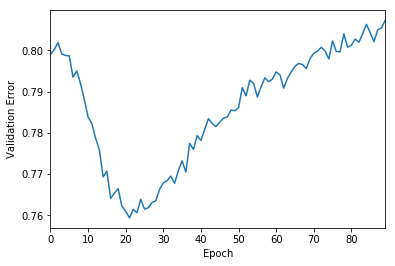

In [151]:
# 3 latent factors
n_factors = 5

# Grabbing out vectors and input
movie_vec, user_vec, user_input, movie_input = latent_test(n_factors)

# training our model
history = train_model(movie_vec, user_vec, user_input, movie_input)

# plotting our loss 
lr_plot(history)

## Collaborative Filtering Using RBMs
Recall that RBMs have two layers: the input/visible layer and the hidden layer. The neurons in each layer communicate with neurons in the other layer but not with neurons in the same layer. 

There is no intralayer communication among the neurons (restricted).

Another important feature of RBMs is that the communication between layers happens in both directions, not just one direction. 

Example: With autoencoders, the neurons communicate with the next layer, passing information only in a feedforward way. 

With RBMs, the neurons in the visible layer communicate with the hidden layer, and then the hidden layer passes back information to the visible layer, going back nad forth several times. 

RBMs perform this communication (back and forth communication) to develop a generative model such taht the reconstructions from the output of the hidden layer are similar to the original inputs. 

RBMs are trying to create a generative model that will help **predict** whether a user will like a movie that the user has never seen based on how similar the movie is to other movies the user has rated and based on how similar the user is to the other user that have rated the movie. 

The **visible** layer will have ```X``` neurons, where ```X``` is the number of movies in the dataset. Each neuron will have a normalized rating value from zero to one, where zero means the user has not seen the movie. 

The closer the normalized rating value is to one, the more the user likes the movie represented by the neuron. 

*The neurons in the visible layer will communicate with neurons in the hidden layer, which will try to learn the underlying, latent features that characterize the user-movie preference.* 

### RMB Neuronal Architecture
For our example: We have an $M * N$ matrix, with $M$ users and $N$ movies. 

To train the RBM, we pass along a batch of $k$ users with their $n$ movie ratings into the neural network and train for a certain number of epochs. 

Each input $x$ that is passed into the neural network represents a single user's rating preference for all $n$ movies, where $n$ is one thousand. Therefor, the visible layer has $n$ nodes, one for each movie. 

We can specify the number of nodes in the hidden layer, which will generally be fewer than the nodes in the visible layer to force the hidden layer to learn the most salient aspects of the original input as efficiently as possible. 

*Gibbs sampling*, the activation of hidden layers results in final outputs that are generated stochastically. This level of randomness helps builds a better-performing and more robust generative model. 

The output after Gibbs sampling $h0$ is passed back through the neural network in the opposite direction in what is called a *backward pass*. 

In the backward pass, the activations in the *forward pass* after Gibbs sampling are fed into the hidden layer and multiplied by the same weights *W* as before. 

Forward pass: $f(v0) = W*V0+hb$ where $f$ is the forward pass, $v0$ is the input vector, $W$ are the weights associated with the neurons of that layer (input to hidden), $hb$ is our biased that is added so neurons are sure to fire. 

Then the product of $f(v0)$ is passed through an **activation function** usually a non-linear activation function. 

The RBM goes through a series of forward and backward passes like this to learn the optimal weights as its attempt to *build a robust generative model*. 

RBMs are the first type of *generative learning models*. 

In essence: By performing Gibbs sampling and retraining weights via forward and backward passes, RBMs are trying to learn the **probability dstribution** of the original input. 

Specifically, RBMs minimize the ***Kullback-Leibler divergence*** which measures how one probability distribution is different from another. 

In our case, RBMs are minimizing the probability distribution of the **reconstructed data**. 

By iteratively readadjusting the weights in the neural net, the RBM learns to *approximate* the original data as best as possible. 

With this newly learned probability distribution, RBMs are able to make predictions about never-before-seen data. 

Let's begin!

In [155]:
# Defining the RBM Class
class RBM(object):
    
    def __init__(self, input_size, output_size, learning_rate, epochs, batchsize):
        
        # Defining Hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initializing weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], 'float')
        self.hb = np.zeros([output_size], 'float')
        self.vb = np.zeros([input_size], 'float')
        
    # Forward pass, h is hidden layer, v is visible layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Backward pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Sampling function Gibbs
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))
    
    # Our Training method
    def train(self, X):
        
        # Placeholders: Weights, Hidden Bias, Visible Bias
        _w = tf.placeholder('float', [self._input_size, self._output_size])
        _hb = tf.placeholder('float', [self._output_size])
        _vb = tf.placeholder('float', [self._input_size])
        
        # Initializing with zeros
        prv_w = np.zeros([self._input_size, self._output_size], 'float')
        prv_hb = np.zeros([self._output_size], 'float')
        prv_vb = np.zeros([self._input_size], 'float')
        
        cur_w = np.zeros([self._input_size, self._output_size], 'float')
        cur_hb = np.zeros([self._output_size], 'float')
        cur_vb = np.zeros([self._input_size], 'float')
        
        # Placeholder - initializes
        v0 = tf.placeholder('float', [None, self._input_size])
        
        # Forward Pass
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        
        # Back Pass
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        
        # Forward pass
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        # Updating weights
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        # error - MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        """
        During the training, forward and backward passes will be made, and the RBM will update weights based on how the generated data compares to the original input. We will print the reconstruction error from each epoch
        """
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    
                    # Initializing batch - window
                    batch = X[start:end]
                    
                    # Computing weights and biases
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                    
                # Error
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print(f'Epoch: {epoch}, reconstruction error: {error}')
                
            # Updating weights biases
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [159]:
# Training

# Convert input_X into ratings
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm = RBM(1000, 1000, 0.3, 500, 200)

# Begin training
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0, reconstruction error: 1.0927095413208008
Epoch: 1, reconstruction error: 1.079160451889038
Epoch: 2, reconstruction error: 1.0790225267410278
Epoch: 3, reconstruction error: 1.0842435359954834
Epoch: 4, reconstruction error: 1.0846835374832153
Epoch: 5, reconstruction error: 1.0836914777755737
Epoch: 6, reconstruction error: 1.0801924467086792
Epoch: 7, reconstruction error: 1.0777864456176758
Epoch: 8, reconstruction error: 1.0747694969177246
Epoch: 9, reconstruction error: 1.0729684829711914
Epoch: 10, reconstruction error: 1.0740875005722046
Epoch: 11, reconstruction error: 1.0723614692687988
Epoch: 12, reconstruction error: 1.0760104656219482
Epoch: 13, reconstruction error: 1.077697515487671
Epoch: 14, reconstruction error: 1.0775375366210938
Epoch: 15, reconstruction error: 1.0741724967956543
Epoch: 16, reconstruction error: 1.0787404775619507
Epoch: 17, reconstruction error: 1.0732024908065796
Epoch: 18, reconstruction error: 1.08559250831604
Epoch: 19, reconstruction 